# Data Science Lab: Lab 5

Submit:
1. A pdf of your notebook with solutions.
2. A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Lab

1. Random Forests
2. Boosting
3. Playing with Ensembling packages, including XGBoost and CatBoost
4. One more time: Revisiting CIFAR-10 and MNIST
5. Getting ready for Kaggle

We will soon open a Kaggle competition made for this class. In that one, you will be participating on your own. This is an intro to get us started, and also an excuse to work with regularization and regression which we have been discussing. You'll revisit some problems from earlier labs, this time using Random Forests, and Boosting. In particular, you should take this opportunity to become familiar with some very useful packages for boosting. I recommend not only the boosting packages in scikit-learn, but also XGBoost, GBM Light, CatBoost and possibly others. You have to download these and get them running, and then read their documentation to figure out how they work, what the hyperparameters are, etc.

Also, the metric we will use in the Kaggle competition is AUC. We will discuss this. In the meantime, you may want to understand how it works. At least one key thing to remember: to get a good AUC score, you need to submit a soft score (probabilities) and not rounded values (i.e., not 0s and 1s).


## Problem 1: Revisiting Logistic Regression and MNIST

We have played with the handwriting recognition problem (the MNIST data set) using decision trees. We have also considered the same problem using multi-class Logistic Regression in a previous Lab. We revisit this one more time.

**Part 1**: Use Random Forests to try to get the best possible *test accuracy* on MNIST. This involves getting acquainted with how Random Forests work, understanding their parameters, and therefore using Cross Validation to find the best settings. How well can you do? You should use the accuracy metric, since this is what you used in the previous Lab  -- therefore this will allow you to compare your results from Random Forests with your results from L1- and L2- Regularized Logistic Regression.

What are the hyperparameters of your best model?

**Part 2**: Use Boosting to do the same. Take the time to understand how XGBoost works (and/or other boosting packages available -- CatBoost is also another favorite). Try your best to tune your hyper-parameters. As added motivation: typically the winners and near-winners of the Kaggle competition are those that are best able to tune and cross validate XGBoost. What are the hyperparameters of your best model?


In [3]:
# Part 1
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Convert to np arrays
X = X.to_numpy()
y = y.to_numpy() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create a RandomForestClassifier object
rf = RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

best_rf = random_search.best_estimator_



Best Parameters:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Best Score:  0.9681333333333335


In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# Convert to np arrays
X = X.to_numpy()
y = y.to_numpy() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(np.unique(y_train))
print(np.unique(y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


[0]	train-mlogloss:2.12645	test-mlogloss:2.13045
[10]	train-mlogloss:1.23633	test-mlogloss:1.26258
[20]	train-mlogloss:0.83214	test-mlogloss:0.87063
[30]	train-mlogloss:0.59103	test-mlogloss:0.63755
[40]	train-mlogloss:0.43605	test-mlogloss:0.48822
[50]	train-mlogloss:0.33131	test-mlogloss:0.38769
[60]	train-mlogloss:0.25889	test-mlogloss:0.31905
[70]	train-mlogloss:0.20731	test-mlogloss:0.27060
[80]	train-mlogloss:0.16983	test-mlogloss:0.23569
[90]	train-mlogloss:0.14152	test-mlogloss:0.20939
[99]	train-mlogloss:0.12185	test-mlogloss:0.19101
Accuracy: 0.9564571428571429


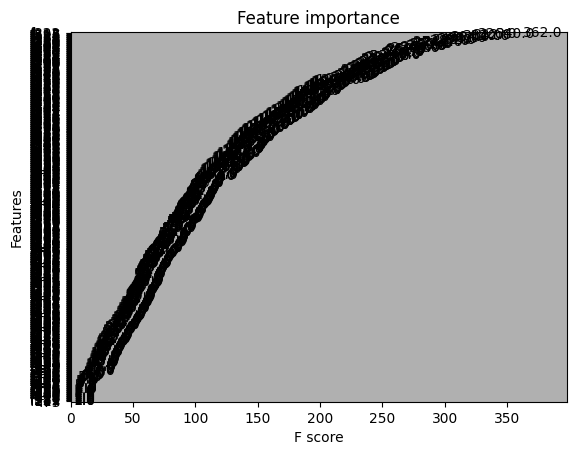

In [2]:
# Part 2
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 6,
    'eta': 0.05,
    'objective': 'multi:softprob',
    'num_class': 10,
    'eval_metric': 'mlogloss'
}

num_rounds = 100

model = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=10, verbose_eval=10)

predictions = model.predict(dtest)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
xgb.plot_importance(model)
plt.show()


## Problem 2: Revisiting Logistic Regression and CIFAR-10

Now that you have your pipeline set up, it should be easy to apply the above procedure to CIFAR-10. If you did something that takes significant computation time, keep in mind that CIFAR-10 is a few times larger.

**Part 1**: What is the best accuracy you can get on the test data, by tuning Random Forests? What are the hyperparameters of your best model?

**Part 2**: What is the best accuracy you can get on the test data, by tuning XGBoost? What are the hyperparameters of your best model?

In [ ]:
# Part 1
# import CIFAR-10 Small data set
data = fetch_openml('CIFAR_10_small')
X = data['data']
y = data['target']

# train-test split on 3/4 - 1/4 on the 20,000 data points, 3/4 - 1/4 coming from the test_size parameter of the train_test_split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Create a RandomForestClassifier object
rf = RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

best_rf = random_search.best_estimator_



In [5]:
from sklearn.datasets import fetch_openml

data = fetch_openml('CIFAR_10_small')
X = data['data']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(np.unique(y_train))
print(np.unique(y_test))

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(np.unique(y_train))
print(np.unique(y_test))

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


[0]	train-mlogloss:2.24990	test-mlogloss:2.27060
[10]	train-mlogloss:1.87449	test-mlogloss:2.05744
[20]	train-mlogloss:1.62334	test-mlogloss:1.92945
[30]	train-mlogloss:1.43405	test-mlogloss:1.83970
[40]	train-mlogloss:1.28307	test-mlogloss:1.77302
[50]	train-mlogloss:1.15961	test-mlogloss:1.72213
[60]	train-mlogloss:1.05517	test-mlogloss:1.68049
[70]	train-mlogloss:0.96546	test-mlogloss:1.64698
[80]	train-mlogloss:0.88800	test-mlogloss:1.61852
[90]	train-mlogloss:0.81928	test-mlogloss:1.59534
[99]	train-mlogloss:0.76342	test-mlogloss:1.57752
Accuracy: 0.4584


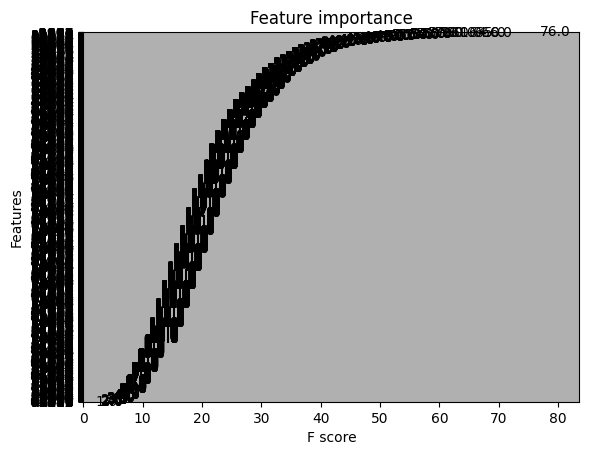

In [6]:
# Part 2
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 8,
    'eta': 0.01,
    'objective': 'multi:softprob',
    'num_class': 10,
    'eval_metric': 'mlogloss'
}

num_rounds = 250

model = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'), (dtest, 'test')], early_stopping_rounds=10, verbose_eval=10)

predictions = model.predict(dtest)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
xgb.plot_importance(model)
plt.show()

## Problem 3: Revisiting Kaggle

This is a continuation of Problem 2 from Lab 3. You already did some first steps there, including making a Kaggle account, and trying ridge and lasso linear regression. You also tried stacking.

**Part 1** (Nothing to hand in) Revisit Lab 3 and your answers there.

**Part 2**: Train a gradient boosting regression, e.g., using XGBoost. What score can you get just from a single XGB? (you will need to optimize over its parameters).

**Part 3**: Do your best to get a more accurate model. Try feature engineering and stacking many models. You are allowed to use any public tool in python. No non-python tools allowed. State what hyperparameters and models you tried, and the corresponding train/test error.

**Part 4**: (Optional)  Read the Kaggle forums, tutorials and Kernels in this competition. This is an excellent way to learn. Include in your report if you find something in the forums you like, or if you made your own post or code post, especially if other Kagglers liked or used it afterwards.

**Other**: Be sure to read and learn the rules of Kaggle! No sharing of code or data outside the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with your Lab partner. This is more important for live competitions of course.

In the real in-class Kaggle competition (which will be next), you will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report, due after the competition closes, you will explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. You can start thinking about this now.

In [ ]:
# Part 2
import pandas as pd

train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")